In [50]:
import sketch
import sympy
from math import log, sqrt, lcm
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm import tqdm as tqdm

In [2]:
!mkdir setsketch_simulation

mkdir: cannot create directory ‘setsketch_simulation’: File exists


In [15]:
m = 2**18  # Number of registers

# Run simulation

In [190]:
%%timeit -n 1 -r 1

debug = False

hll, hll2 = sketch.setsketch.CSetSketch(m), sketch.setsketch.CSetSketch(m)

if debug: ss1, ss2 = set(), set()
# step1, step2, maxval = 1, 5, 2*10**6
# step1, step2, maxval = sympy.nextprime(125), sympy.nextprime(208), 10**9
step1, step2, maxval = 2087, 1249, 3*10**13
# step1, step2, maxval = 31, 17, 10**7
assert sympy.isprime(step1) and sympy.isprime(step2)
for c,i in enumerate(range(step1, maxval+1, step1)):
    hll.addh(str(i))
    if (c+1) & c == 0:  # c+1 is a power of 2
        hll.write(f'setsketch_simulation/{step1}_{i}')
#     if debug: ss1.add(str(i))

for c,i in enumerate(range(step2, maxval+1, step2)):
    hll2.addh(str(i))
    if (c+1) & c == 0:  # c+1 is a power of 2
        hll2.write(f'setsketch_simulation/{step2}_{i}')
#     if debug: ss2.add(str(i))
    

4h 52min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [191]:
!du -sch setsketch_simulation/*
# !rm setsketch_simulation/*

2.0M	setsketch_simulation/1249_10231808
1.9M	setsketch_simulation/1249_10477371392
1.9M	setsketch_simulation/1249_10728828305408
2.0M	setsketch_simulation/1249_1249
1.9M	setsketch_simulation/1249_1278976
1.9M	setsketch_simulation/1249_1309671424
2.0M	setsketch_simulation/1249_1341103538176
1.9M	setsketch_simulation/1249_159872
1.9M	setsketch_simulation/1249_163708928
1.9M	setsketch_simulation/1249_167637942272
1.9M	setsketch_simulation/1249_19984
2.0M	setsketch_simulation/1249_20463616
1.9M	setsketch_simulation/1249_20954742784
1.9M	setsketch_simulation/1249_21457656610816
1.9M	setsketch_simulation/1249_2498
1.9M	setsketch_simulation/1249_2557952
1.9M	setsketch_simulation/1249_2619342848
2.0M	setsketch_simulation/1249_2682207076352
1.9M	setsketch_simulation/1249_319744
1.9M	setsketch_simulation/1249_327417856
2.0M	setsketch_simulation/1249_335275884544
1.9M	setsketch_simulation/1249_39968
2.0M	setsketch_simulation/1249_40927232
1.9M	setsketch_simulation/1249_41909485568
1.9M	setsketch_

# Cardinality estimation

In [192]:
dfs = []
for p in Path('setsketch_simulation/').glob('*'):
    hll = sketch.setsketch.CSetSketch(str(p))
    step, maxval = map(int,p.name.split('_'))
    dfs.append({
        'step':  step,
        'card': maxval // step,
        'card_est': hll.report()
    })
df = pd.DataFrame(dfs)
df.head()

,step,card,card_est
0,1249,32768,3.269892e+04
1,1249,2048,2.049483e+03
2,1249,16384,1.637624e+04
3,1249,268435456,2.681913e+08
4,2087,1024,1.023741e+03


/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


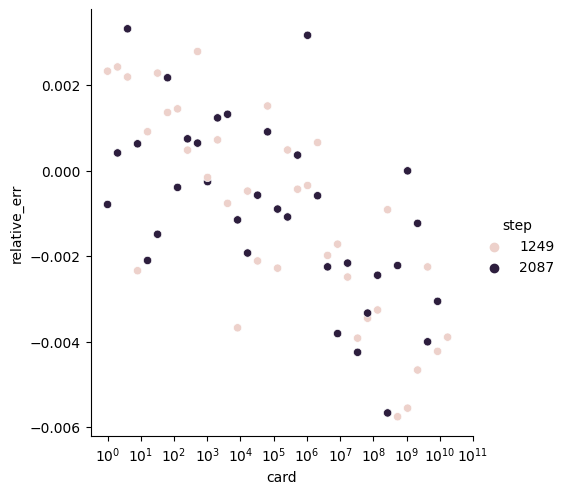

In [205]:
df['relative_err'] = (df.card_est-df.card)/df.card
df.relative_err.describe()

g = sns.relplot(data=df, x='card',y='relative_err',hue='step',)
g.set(xscale='log')
_ = g.set(xticks=[10**i for i in range(12)])

### For cardinality estimation the theoretical relative standard error is 1/sqrt(m). If the error is distribited normally, we expect to fit into 2-3 standard errors almost always. Let's check it.

In [201]:
print('theoretical relative standard error:', 1/sqrt(m))

theoretical relative standard error: 0.001953125


In [202]:
df['relative_err'] = (df.card_est-df.card)/df.card
df.relative_err.describe()

df['relative_err / relative_stderr'] = df.relative_err / (1/sqrt(m))

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


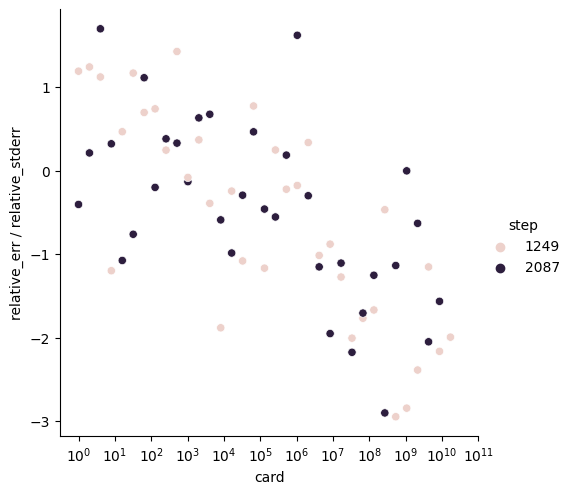

In [204]:
g = sns.relplot(data=df, x='card',y='relative_err / relative_stderr',hue='step',)
g.set(xscale='log')
_ = g.set(xticks=[10**i for i in range(12)])

# Jaccard estimation

In [206]:
dfs = []
for p1 in tqdm(list(Path('setsketch_simulation/').glob('*'))):
    hll1 = sketch.setsketch.CSetSketch(str(p1))
    step1, maxval1 = map(int,p1.name.split('_'))
    for p2 in Path('setsketch_simulation/').glob('*'):
        hll2 = sketch.setsketch.CSetSketch(str(p2))
        step2, maxval2 = map(int,p2.name.split('_'))
        
        card1, card2 = maxval1 // step1, maxval2 // step2
        intersection = min(maxval1, maxval2) // lcm(step1,step2)
        union = card1 + card2 - intersection
        jaccard = intersection / union

        dfs.append({
            'step1':  step1,
            'step2':  step2,
            'card1': card1,
            'card2': card2, 
            'jaccard': jaccard,
            'jaccard_est': sketch.setsketch.jaccard_index(hll1, hll2)
        })
df = pd.DataFrame(dfs)
df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:54<00:00,  1.26it/s]


,step1,step2,card1,card2,jaccard,jaccard_est
0,1249,1249,32768,32768,1.000000,1.000000
1,1249,1249,32768,2048,0.062500,0.061386
2,1249,1249,32768,16384,0.500000,0.498844
3,1249,1249,32768,268435456,0.000122,0.000122
4,1249,2087,32768,1024,0.000000,0.000000


In [207]:
df.jaccard.describe()

count    4761.000000
mean        0.041808
std         0.148452
min         0.000000
25%         0.000000
50%         0.000004
75%         0.000977
max         1.000000
Name: jaccard, dtype: float64

### Absolute error

In [215]:
df['absolute_err'] = (df.jaccard_est - df.jaccard)
df.absolute_err.describe()

count    4.761000e+03
mean    -1.233460e-05
std      2.649228e-04
min     -2.567291e-03
25%     -9.536743e-07
50%      0.000000e+00
75%      1.950367e-06
max      2.704620e-03
Name: absolute_err, dtype: float64

In [216]:
print(df[(df.jaccard==0.0)].absolute_err.describe())
print(df[(df.jaccard==1.0)].absolute_err.describe())

count    1322.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: absolute_err, dtype: float64
count    69.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: absolute_err, dtype: float64


jaccard of 0.0 or 1.0 is estimated with absolute error of 0.0

Theoretical absolute standard error for jaccard estimation should be sqrt(J*(1-J)/m). For J=0.0 or J=1.0 the real absolute error was 0.0, so this is satisfied. Let's check for the rest. 

In [217]:
mask = (df.jaccard > 0.0) & (df.jaccard < 1.0)
j = df[mask].jaccard
df.loc[mask, 'err / stderr'] = df[mask].absolute_err / (j*(1-j) / m).apply(sqrt)
df.loc[mask,'err / stderr'].describe(percentiles=[0.001, 0.025,0.975, 0.999])

count    3370.000000
mean       -0.013366
std         0.865806
min        -2.952262
0.1%       -2.719034
2.5%       -1.769496
50%        -0.062500
97.5%       1.885227
99.9%       3.344291
max         4.294975
Name: err / stderr, dtype: float64

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


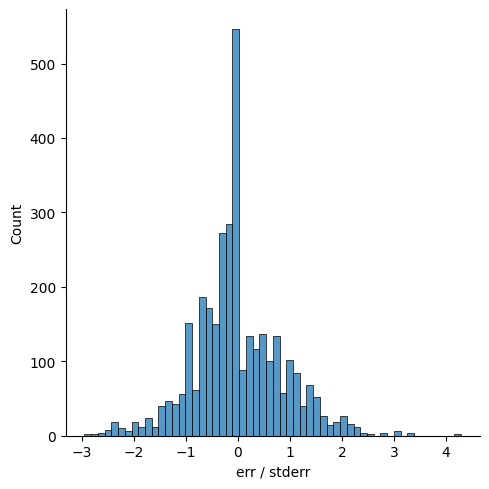

In [218]:
sns.displot(data=df.loc[mask,'err / stderr'])

In [219]:
df[df['err / stderr'] > 3.0]

,step1,step2,card1,card2,jaccard,jaccard_est,absolute_err,err / stderr
1351,2087,1249,33554432,33554432,0.000240,0.000340,0.000100,3.304124
2618,2087,1249,2147483648,16777216,0.000004,0.000015,0.000012,3.067167
2779,1249,2087,33554432,33554432,0.000240,0.000340,0.000100,3.304124
2817,1249,2087,33554432,16777216,0.000267,0.000366,0.000099,3.111269
2963,2087,1249,67108864,16777216,0.000096,0.000160,0.000064,3.367780
3377,2087,1249,134217728,16777216,0.000053,0.000114,0.000061,4.294975
3862,2087,2087,1073741824,8589934592,0.125000,0.127003,0.002003,3.100490
3973,2087,1249,16777216,33554432,0.000267,0.000366,0.000099,3.111269
4522,1249,2087,16777216,2147483648,0.000004,0.000015,0.000012,3.067167
4527,1249,2087,16777216,67108864,0.000096,0.000160,0.000064,3.367780


/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


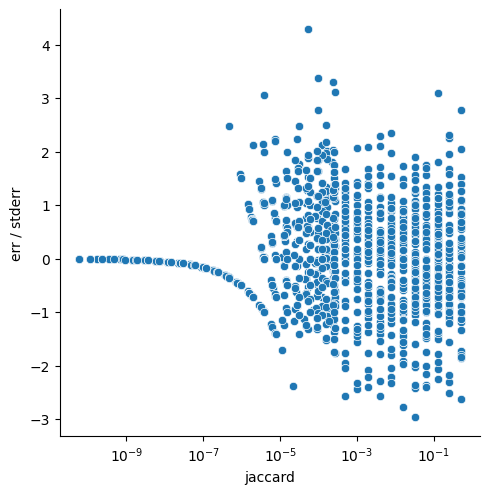

In [220]:
g = sns.relplot(data=df[mask], x='jaccard', y='err / stderr')
g.set(xscale='log')

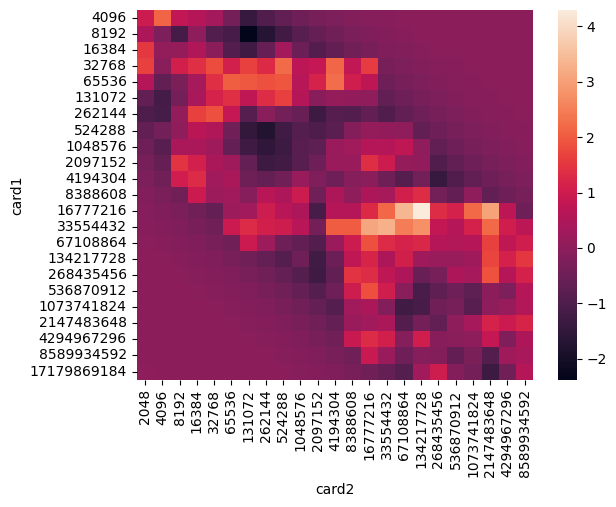

In [221]:
pdf = df[(df.step1 < df.step2)&mask].pivot(index='card1', columns='card2',values='err / stderr')
g = sns.heatmap(data=pdf)
# g.set(xscale='log')
# g.set(yscale='log')

### Relative error is defined for 0.0 < jaccard < 1.0 only

In [222]:
mask = (df.jaccard > 0.0) & (df.jaccard < 1.0)

In [223]:
df.loc[mask, 'relative_err'] = df[mask].absolute_err / df[mask].jaccard
df[mask].relative_err.describe()

count    3370.000000
mean       -0.219362
std         0.627599
min        -1.000000
25%        -1.000000
50%        -0.007324
75%         0.016602
max         7.000000
Name: relative_err, dtype: float64

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


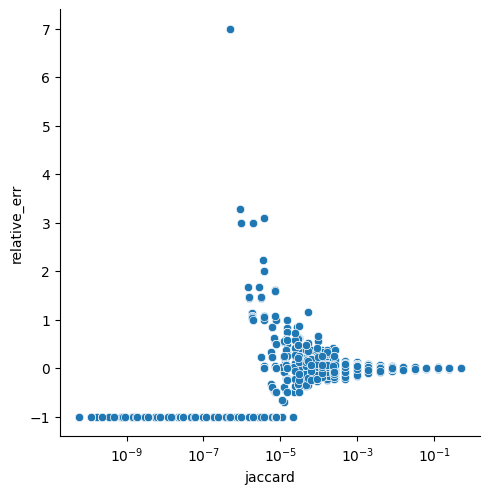

In [224]:
g = sns.relplot(data=df[mask], x='jaccard', y='relative_err')
g.set(xscale='log')

In [231]:
df[mask&(df.relative_err>3)]

,step1,step2,card1,card2,jaccard,jaccard_est,absolute_err,err / stderr,relative_err,relative_err / relative_stderr
57,1249,2087,32768,16777216,8.923276e-07,0.000004,0.000003,1.583956,3.274996,1.583956
313,2087,2087,1024,2147483648,4.768372e-07,0.000004,0.000003,2.474874,7.000000,2.474874
2557,2087,2087,2147483648,1024,4.768372e-07,0.000004,0.000003,2.474874,7.000000,2.474874
2618,2087,1249,2147483648,16777216,3.713984e-06,0.000015,0.000012,3.067167,3.108469,3.067167
3933,2087,1249,16777216,32768,8.923276e-07,0.000004,0.000003,1.583956,3.274996,1.583956
4522,1249,2087,16777216,2147483648,3.713984e-06,0.000015,0.000012,3.067167,3.108469,3.067167


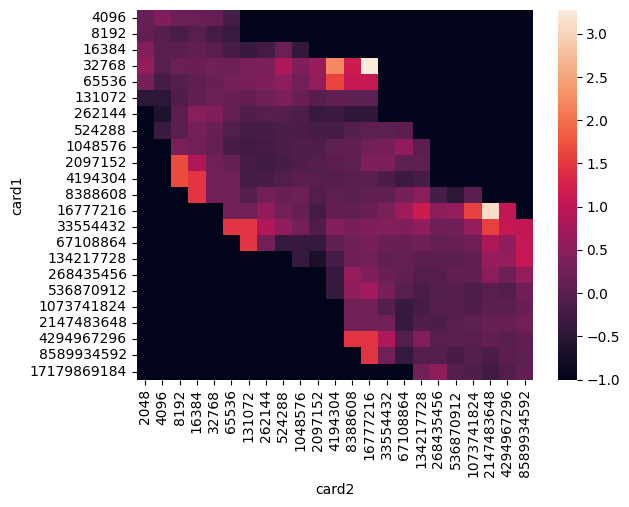

In [225]:
pdf = df[mask&(df.step1 < df.step2)&(df.jaccard>0)].pivot(index='card1', columns='card2',values='relative_err')


g = sns.heatmap(data=pdf)
# g.set(xscale='log')
# g.set(yscale='log')

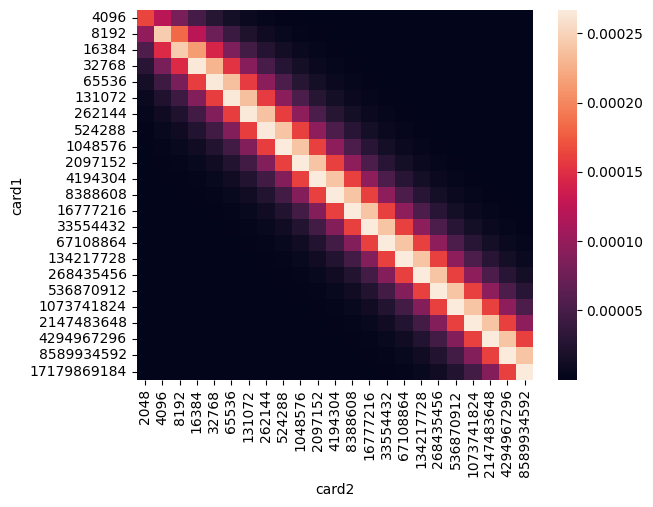

In [226]:
pdf = df[mask&(df.step1 < df.step2)&(df.jaccard>0)].pivot(index='card1', columns='card2',values='jaccard')


g = sns.heatmap(data=pdf)
# g.set(xscale='log')
# g.set(yscale='log')

In [227]:
df.loc[mask, 'relative_err / relative_stderr'] = df.loc[mask, 'relative_err'] / ((1/j - 1)/m).apply(sqrt)

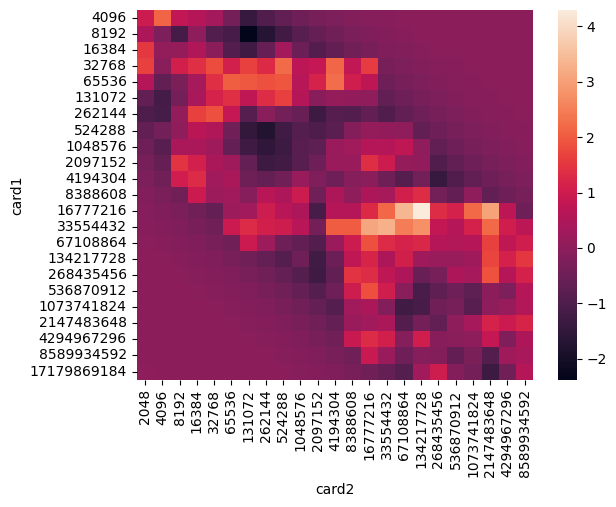

In [228]:
pdf = df[(df.step1 < df.step2)&mask].pivot(index='card1', columns='card2',values='relative_err / relative_stderr')
g = sns.heatmap(data=pdf)
# g.set(xscale='log')
# g.set(yscale='log')